<a href="https://colab.research.google.com/github/ttogle918/Competition/blob/main/%ED%8C%94%EB%8B%B9%EB%8C%90%20%ED%99%8D%EC%88%98%20%EC%95%88%EC%A0%84%EC%9A%B4%EC%98%81%EC%97%90%20%EB%94%B0%EB%A5%B8%20%ED%95%9C%EA%B0%95%20%EC%88%98%EC%9C%84%EC%98%88%EC%B8%A1%20AI%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Data
    ├ Water Data
    │ ├ data_2012.csv
    │   ├ ymdhm : 년월일시분
    │   ├ swl : 팔당댐 현재수위 (단위: El.m)
    │   ├ inf : 팔당댐 유입량 (단위: m^3/s)
    │   ├ sfw : 팔당댐 저수량 (단위: 만m^3)
    │   ├ ecpc : 팔당댐 공용량 (단위: 백만m^3)
    │   ├ tototf : 총 방류량 (단위: m^3/s)
    │   ├ tide_level : 강화대교 조위 (단위: cm)
    │   ├ wl_1018662 : 청담대교 수위 (단위: cm)
    │   ├ fw_1018662 : 청담대교 유량 (단위: m^3/s)
    │   ├ wl_1018680 : 잠수교 수위 (단위: cm)
    │   ├ fw_1018680 : 잠수교 유량 (단위: m^3/s)
    │   ├ wl_1018683 : 한강대교 수위 (단위: cm)
    │   ├ fw_1018683 : 한강대교 유량 (단위: m^3/s)
    │   ├ wl_1019630 : 행주대교 수위 (단위: cm)
    │   └ fw_1019630 : 행주대교 유량 (단위: m^3/s)
    │ ├ data_2013.csv
    …
    └ └ data_2022.csv
    └ RainFall Data
    │ ├ rf_2012.csv
    │   ├ YMDHM : 년월일시분
    │   ├ rf_10184100 : 대곡교 강수량
    │   ├ rf_10184110 : 진관교 강수량
    │   └ rf_10184140 : 송정동 강수량
    │ ├ rf_2013.csv
    …
    └ └ rf_2022.csv

    한강다리 교량간 거리
    - 팔당댐 - 청담대교 : 4.35+3.25+4.85+2.9+3.4+0.24+1.25+0.75+0.85+2.7
    - 청담대교 - 잠수교(반포대교) : 0.75+2.1+1.75+1.2+2.05
    - 잠수교 - 한강대교 : 1.5+2.25
    - 한강대교 - 행주대교 : 0.6 +1.15+1.1+1.1+1.75+0.45+1.55+1+2.45+2.35+1.5+2
    [교량간거리 참조](https://m.blog.naver.com/en0316/30107377248)

In [14]:
# meter로 변환. 유량과 비교할 수 있을까
dist_팔당댐_청담대교 = (4.35+3.25+4.85+2.9+3.4+0.24+1.25+0.75+0.85+2.7)*1000
dist_청담_잠수교 = (0.75+2.1+1.75+1.2+2.05)*1000
dist_잠수_한강대교 = (1.5+2.25)*1000
dist_한강_행주대교 = (0.6 +1.15+1.1+1.1+1.75+0.45+1.55+1+2.45+2.35+1.5+2)*1000
dist_팔당댐_청담대교, dist_청담_잠수교, dist_잠수_한강대교, dist_한강_행주대교

(24540.0, 7850.0, 3750.0, 17000.0)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from glob import glob
from tqdm import tqdm
from scipy import interpolate

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset/dacon/competition_data.zip'

import zipfile
from zipfile import ZipFile

with zipfile.ZipFile(f'{path}', 'r') as obj:
  namelist = obj.namelist()
  obj.extractall('/content/competition_data')
namelist

In [ ]:
w_list = sorted(glob("competition_data/water_data/*.csv"))
rf_list = sorted(glob("competition_data/rf_data/*.csv"))
w_list, rf_list

In [ ]:
df = pd.DataFrame(pd.merge(pd.read_csv(w_list[0]), pd.read_csv(rf_list[0])))
for w, rf in zip(w_list[1:], rf_list[1:]) :
  df_sample = pd.merge(pd.read_csv(w), pd.read_csv(rf))
  df = df.append(df_sample)
  # print(df.shape)
df = df.reset_index(drop=True)
df = df.sort_values(by=['ymdhm'], axis=0)
df.head(5)

In [8]:
# 단위 맞추기
df['sfw'] = df['sfw']*10000
df['ecpc'] = df['ecpc']*1000000

In [9]:
df.describe()

,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
count,276336.000000,276336.000000,2.763360e+05,2.763360e+05,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.0,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000
mean,25.071728,548.533893,2.193567e+06,2.464391e+07,542.022193,345.631700,320.857472,746.826551,307.943626,0.0,304.590401,600.970021,292.408619,1056.807758,0.034074,0.038265,0.035985
std,0.458487,1110.983698,1.061519e+05,1.061480e+07,1104.323528,174.250734,90.977494,1077.388189,82.622234,0.0,79.441943,1376.848129,68.893322,1428.279212,0.338607,0.370553,0.360769
min,0.000000,-990.000000,-1.000000e+02,2.150000e+06,-990.000000,39.000000,0.000000,243.290000,0.000000,0.0,0.000000,-3522.710000,0.000000,212.040000,0.000000,0.000000,0.000000
25%,24.980000,127.410000,2.117700e+06,1.469000e+07,132.000000,192.000000,286.700000,319.840000,276.200000,0.0,274.000000,205.082500,266.300000,449.120000,0.000000,0.000000,0.000000
50%,25.100000,249.500000,2.176300e+06,2.638000e+07,174.976207,324.000000,305.700000,441.000000,296.200000,0.0,294.000000,355.980000,285.300000,679.420000,0.000000,0.000000,0.000000
75%,25.190000,530.000000,2.293100e+06,3.223000e+07,505.000000,487.000000,341.700000,725.690000,328.200000,0.0,326.000000,709.710000,315.300000,1142.220000,0.000000,0.000000,0.000000
max,25.449000,25991.500000,2.418500e+06,2.440100e+08,25791.500000,842.000000,1287.700000,9405.640000,1146.200000,0.0,1080.000000,25289.170000,843.300000,29854.120000,24.000000,21.000000,24.000000


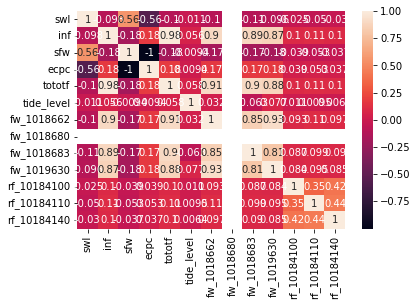

In [10]:
features = ['swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level', 'fw_1018662', 'fw_1018680', 'fw_1018683', 'fw_1019630', 'rf_10184100', 'rf_10184110', 'rf_10184140']
label = ['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']

sns.heatmap(df.drop(label, axis=1).corr(), annot=True)

In [12]:
mmin = df.shape[0]
for k in na_idxes.keys() :
  m = na_idxes[k].min()
  print(k, m)
  if mmin > m :
    mmin = m
mmin

ymdhm nan
swl nan
inf nan
sfw nan
ecpc nan
tototf nan
tide_level nan
wl_1018662 nan
fw_1018662 nan
wl_1018680 nan
fw_1018680 nan
wl_1018683 nan
fw_1018683 nan
wl_1019630 nan
fw_1019630 nan
rf_10184100 nan
rf_10184110 nan
rf_10184140 nan


276336

In [11]:
na_idxes = {}
print(f'shape : {df.shape}')
print(f'null : {df.isna().sum()}')
for col in df.columns :
  na_idxes[col] = df[df[col].isna() == True].index
df = df.fillna(df.interpolate())
print(f'null : {df.isna().sum()}')

shape : (276336, 18)
null : ymdhm          0
swl            0
inf            0
sfw            0
ecpc           0
tototf         0
tide_level     0
wl_1018662     0
fw_1018662     0
wl_1018680     0
fw_1018680     0
wl_1018683     0
fw_1018683     0
wl_1019630     0
fw_1019630     0
rf_10184100    0
rf_10184110    0
rf_10184140    0
dtype: int64
null : ymdhm          0
swl            0
inf            0
sfw            0
ecpc           0
tototf         0
tide_level     0
wl_1018662     0
fw_1018662     0
wl_1018680     0
fw_1018680     0
wl_1018683     0
fw_1018683     0
wl_1019630     0
fw_1019630     0
rf_10184100    0
rf_10184110    0
rf_10184140    0
dtype: int64
